In [ ]:
!pip install datasets transformers==4.28.0 torchinfo sentencepiece sacremoses

In [2]:
# clear gpu
# import gc
# del transformer
# gc.collect()
# torch.cuda.empty_cache()

In [3]:
import numpy as np
import pandas as pd
from torch.utils.data import dataset
import torchinfo
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import math
import datasets
from transformers import AutoTokenizer, DataCollatorForSeq2Seq
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=2048):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)

        # PE(pos, 2i) = sin(pos / 10000^(2i / d_model))
        # PE(pos, 2i+1) = cos(pos / 10000^(2i / d_model))
        position = torch.arange(max_len).unsqueeze(1)
        exp_term = torch.arange(0, d_model, 2)
        pe = torch.zeros(1, max_len, d_model)
        div_term = torch.exp(exp_term * (-np.log(10000.0)) / d_model)
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

### Encoder

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, causal=False):
        super().__init__()

        self.d_k = d_k
        self.d_model = d_model
        self.n_heads = n_heads
        self.max_len = max_len
        self.causal = causal

        # generate matrices weights
        self.query = nn.Linear(d_model, d_k * n_heads) # (d_model x d_k)
        self.key = nn.Linear(d_model, d_k * n_heads) # (d_model x d_k)
        self.value = nn.Linear(d_model, d_k * n_heads) # (d_model x d_k)

        if self.causal:
            cm = torch.tril(torch.ones(max_len, max_len))
            self.register_buffer(
                'causal_mask',
                cm.view(1, 1, max_len, max_len)
            )

        # final linear layer
        self.final_layer = nn.Linear(d_k * n_heads, d_model)


    def forward(self, q, k, v, pad_mask=None):
        # x -> batch_size (N) x T x d_model
        q = self.query(q)   # N x T x h*d_k
        k = self.key(k) # N x T x h*d_k
        v = self.value(v) # N x T x h*d_v


        # k, v will come from encoder output, q will come from decoder
        N = q.shape[0] # store batch size
        T_encoder = k.shape[1] # store sequence dimension
        T_decoder = q.shape[1]

        # tranform to (N x T x h, d_k) -> (N x h x T x d_k)
        q = q.view(N, T_decoder, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(N, T_encoder, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(N, T_encoder, self.n_heads, self.d_k).transpose(1, 2)

        # (N x h x T x d_k) * (N x h x d_k x T) -> (N x h x T x T)
        attn_scores = q @ k.transpose(-1, -2) / np.sqrt(self.d_k)
        if pad_mask is not None:
            # pad_mask is vector size 1 x T
            attn_scores = attn_scores.masked_fill(
                pad_mask[:, None, None, :] == 0, float('-inf')
            )
        if self.causal:
            attn_scores = attn_scores.masked_fill(
            self.causal_mask[:, :, :T_decoder, :T_encoder] == 0, float('-inf')
            )
        attn_weights = F.softmax(attn_scores, dim=-1)

        # (N x h x T x T) * (N x h x T x d_v) -> (N x h x T x d_v)
        A = attn_weights @ v
        # reshape to (N x T x h*d_v)
        A = A.transpose(1, 2)
        A = A.contiguous().view(N, T_decoder, self.n_heads * self.d_k)

        # (N x T x d_k * h) -> (N x T x d_model)
        return self.final_layer(A)

In [6]:
class EncoderBlock(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.d_k = d_k
        self.d_model = d_model
        self.n_heads = n_heads
        self.max_len = max_len

        self.mha = MultiHeadAttention(d_k, d_model, n_heads, max_len)
        self.ln1 = nn.LayerNorm(d_model)
        # (N x T x d_model) -> (N x T)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(p=dropout_prob)
        )
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(p=dropout_prob)

    def forward(self, x, pad_mask=None):
        # x = (N x T x d_model) -> (N x T x d_model)
        x = self.ln1(x + self.mha(x, x, x, pad_mask=pad_mask))
        x = self.ln2(x + self.ann(x))
        x = self.drop(x)
        return x


In [7]:
class DecoderBlock(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.d_k = d_k
        self.d_model = d_model
        self.n_heads = n_heads

        self.mha1 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=True)
        self.mha2 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ln3 = nn.LayerNorm(d_model)
        # (N x T x d_model) -> (N x T)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(p=dropout_prob)
        )
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x_decoder, x_encoder, dec_mask=None, enc_mask=None):
        # (N x T x d_model) -> (N x T x d_model)

        # first multihead attn: masked with decoder inputs
        x = self.ln1(
            x_decoder + self.mha1(
                x_decoder, x_decoder, x_decoder, pad_mask=dec_mask
                )
            )

        # second multihead attention: non-masked with q from decoder, k and v from encoder
        x = self.ln2(
            x + self.mha2(
                x, x_encoder, x_encoder, pad_mask=enc_mask
                )
            )

        x = self.ln3(x + self.ann(x))
        x = self.dropout(x)
        return x

In [8]:
class Encoder(nn.Module):
    def __init__(
            self,
            d_k,
            max_len,
            vocab_size,
            d_model,
            n_heads,
            n_layers,
            dropout=0.1
            ):
        super().__init__()

        # after tokenization -> batch_size x max_len (N x T)

        self.embed = nn.Embedding(vocab_size, d_model)
        # after embedding -> batch_size x max_len x d_model (N x T x d_model)

        self.positional_encoding = PositionalEncoding(d_model, max_len=max_len)
        transformer_blocks = [
            EncoderBlock(
            d_k,
            d_model,
            n_heads,
            max_len,
            dropout_prob=dropout
            ) for _ in range(n_layers)
        ]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.layer_norm = nn.LayerNorm(d_model)


    def forward(self, x, pad_mask=None):
        x = self.embed(x)
        x = self.positional_encoding(x)
        for block in self.transformer_blocks:
            x = block(x, pad_mask=pad_mask)
        x = self.layer_norm(x)
        return x

In [9]:
class Decoder(nn.Module):
    def __init__(
            self,
            d_k,
            max_len,
            vocab_size,
            d_model,
            n_heads,
            n_layers,
            dropout=0.1
            ):
        super().__init__()

        # after tokenization -> batch_size x max_len (N x T)

        self.embed = nn.Embedding(vocab_size, d_model)
        # after embedding -> batch_size x max_len x d_model (N x T x d_model)

        self.positional_encoding = PositionalEncoding(d_model, max_len=max_len)
        transformer_blocks = [
            DecoderBlock(
            d_k,
            d_model,
            n_heads,
            max_len,
            dropout_prob=dropout
            ) for _ in range(n_layers)
        ]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.layer_norm = nn.LayerNorm(d_model)
        self.final_layer = nn.Linear(d_model, vocab_size)


    def forward(self, x, x_encoder, dec_mask=None, enc_mask=None):
        x = self.embed(x)
        x = self.positional_encoding(x)
        for block in self.transformer_blocks:
            x = block(x, x_encoder, dec_mask, enc_mask)
        x = self.layer_norm(x)
        x = self.final_layer(x)
        return x

In [10]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x_dec, x_enc, mask_dec=None, mask_enc=None):
        x_enc = self.encoder(x_enc, mask_enc)
        x = self.decoder(x_dec, x_enc, mask_dec, mask_enc)
        return x

In [11]:
encoder = Encoder(
    d_k=32,
    max_len=512,
    vocab_size=20_000,
    d_model=64,
    n_heads=4,
    n_layers=2,
    dropout=0.1,
)

decoder = Decoder(
    d_k=32,
    max_len=256,
    vocab_size=10_000,
    d_model=64,
    n_heads=4,
    n_layers=2,
    dropout=0.1,
)

transformer = Transformer(encoder, decoder)

In [12]:
dummy_enc = torch.randint(0, 20_000, (8, 512))
dummy_enc_mask = torch.ones((8, 512))
dummy_enc_mask[:, 256:] = 0

dummy_dec= torch.randint(0, 10_000, (8, 256))
dummy_dec_mask = torch.ones((8, 256))
dummy_dec_mask[:, 128:] = 0

outputs = transformer(
    dummy_dec,
    dummy_enc,
    dummy_dec_mask,
    dummy_enc_mask
)
print(dummy_dec.shape)
print(outputs.shape)

torch.Size([8, 256])
torch.Size([8, 256, 10000])


In [13]:
# download data
!wget -nc https://lazyprogrammer.me/course_files/nlp3/spa.txt

--2023-07-14 20:45:55--  https://lazyprogrammer.me/course_files/nlp3/spa.txt
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘spa.txt’

spa.txt                 [      <=>           ]   7.45M  7.10MB/s    in 1.1s    

2023-07-14 20:45:56 (7.10 MB/s) - ‘spa.txt’ saved [7817148]



In [14]:
!head spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Hi.	Hola.
Run!	¡Corre!
Who?	¿Quién?
Wow!	¡Órale!
Fire!	¡Fuego!
Fire!	¡Incendio!
Fire!	¡Disparad!


In [15]:
df = pd.read_csv('spa.txt', sep='\t')
df.columns = ['en', 'es']
df.to_csv('spa.csv', index=None)

In [16]:
raw_ds = datasets.load_dataset('csv', data_files='spa.csv')
split_ds = raw_ds['train'].train_test_split(test_size=0.2, seed=42)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-bc20e1f6fbf0d2ba/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

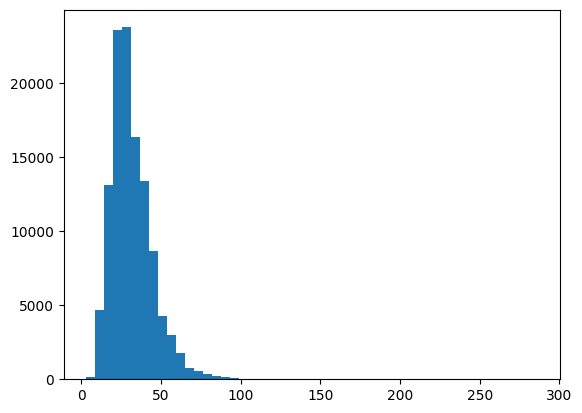

In [17]:
chars_len = [len(phrase) for phrase in raw_ds['train']['en']]
plt.hist(chars_len, bins=50)
plt.show()

47


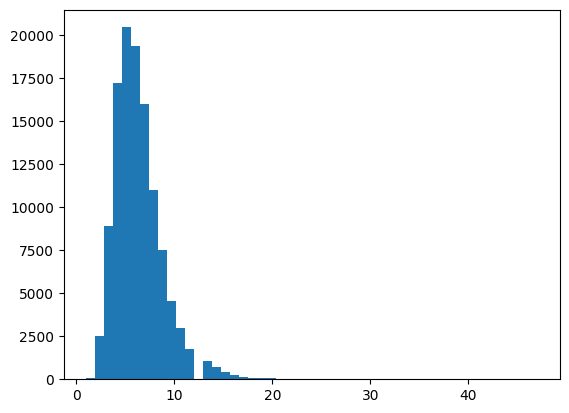

In [18]:
words_len = [len(phrase.split()) for phrase in raw_ds['train']['en']]
print(max(words_len))
plt.hist(words_len, bins=50)
plt.show()

In [19]:
checkpoint = 'Helsinki-NLP/opus-mt-en-es'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

max_len = 128

def tokenize_dataset(batch):
    tokenized_inputs = tokenizer(
        batch['en'], truncation=True, max_length=max_len,
    )
    tokenized_targets = tokenizer(
        text_target=batch['es'], truncation=True, max_length=max_len,
    )

    tokenized_inputs['labels'] = tokenized_targets['input_ids']
    return tokenized_inputs


tokenized_ds = split_ds.map(
    tokenize_dataset,
    batched=True,
    remove_columns=split_ds['train'].column_names,
)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)
tokenizer.add_special_tokens({'cls_token': '<s>'})

train_dataloader = DataLoader(
    tokenized_ds['train'],
    batch_size=256,
    shuffle=True,
    collate_fn=data_collator,
)

test_dataloader = DataLoader(
    tokenized_ds['test'],
    batch_size=256,
    collate_fn=data_collator,
)

encoder = Encoder(
    d_k=16,
    max_len=max_len,
    vocab_size=tokenizer.vocab_size+1,
    d_model=64,
    n_heads=4,
    n_layers=2,
    dropout=0.1
)

decoder = Decoder(
    d_k=16,
    max_len=max_len,
    vocab_size=tokenizer.vocab_size+1,
    d_model=64,
    n_heads=4,
    n_layers=2,
    dropout=0.1
)

transformer = Transformer(encoder, decoder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder.to(device)
decoder.to(device)

optimizer = optim.Adam(transformer.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=-100)

def train_model(transformer, num_epochs, train_dataloader, eval_dataloader, criterion, optimizer):
    train_losses = []
    eval_losses = []
    for epoch in range(1, num_epochs+1):
        train_loss = []
        transformer.train()
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            enc_input = batch['input_ids'].clone().detach()
            enc_attn_mask = batch['attention_mask']
            targets = batch['labels']
            dec_input = torch.roll(batch['labels'], shifts=1, dims=1)
            dec_input[:, 0] = 65_001

            # tokenizer uses pad token as -100, which is not on vocab(0 to 20000)
            dec_input = dec_input.masked_fill(
                dec_input == -100, tokenizer.pad_token_id
            )

            # create decoder mask
            dec_attn_mask = torch.ones_like(dec_input)
            dec_attn_mask = dec_attn_mask.masked_fill(
                dec_input == tokenizer.pad_token_id, 0
            )

            optimizer.zero_grad()
            outputs = transformer(
                dec_input,
                enc_input,
                dec_attn_mask,
                enc_attn_mask,
            )

            # outputs -> (N x T x vocab_size)
            # targets -> (N x T)
            loss = criterion(outputs.transpose(2, 1), targets)
            optimizer.step()

            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)
        train_losses.append(train_loss)

        eval_loss = []
        transformer.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            enc_input = batch['input_ids'].clone().detach()
            enc_attn_mask = batch['attention_mask']
            targets = batch['labels']
            dec_input = torch.roll(batch['labels'], shifts=1, dims=1)
            dec_input[:, 0] = 65_001

            # tokenizer uses pad token as -100, which is not on vocab(0 to 20000)
            dec_input = dec_input.masked_fill(
                dec_input == -100, tokenizer.pad_token_id
            )

            # create decoder mask
            dec_attn_mask = torch.ones_like(dec_input)
            dec_attn_mask = dec_attn_mask.masked_fill(
                dec_input == tokenizer.pad_token_id, 0
            )

            optimizer.zero_grad()
            outputs = transformer(
                dec_input,
                enc_input,
                dec_attn_mask,
                enc_attn_mask,
            )

            # outputs -> (N x T x vocab_size)
            # targets -> (N x T)
            loss = criterion(outputs.transpose(2, 1), targets)
            eval_losses.append(loss)

        eval_losses = np.mean(eval_loss)
        eval_losses.append(eval_loss)

        print(f"Epoch {epoch} / {num_epochs}: \t Train loss --> {train_loss:.4f} \t Eval loss --> {eval_loss:.4f}")
        return train_losses, eval_losses

Map:   0%|          | 0/92195 [00:00<?, ? examples/s]

Map:   0%|          | 0/23049 [00:00<?, ? examples/s]

In [ ]:
num_epochs=5

train_losses, eval_losses = train_model(
    transformer,
    num_epochs,
    train_dataloader,
    test_dataloader,
    criterion,
    optimizer
)

In [ ]:
enc_input = tokenized_ds['test'][10]['input_ids']
enc_input = tokenizer(enc_input, return_tensor='pt')

enc_input_ids = enc_input['input_ids'].to(device)
enc_attn_mask = enc_input['attention_mask'].to(device)

enc_output = encoder(
    enc_input_ids,
    enc_attn_mask
)

dec_input = '<s>'
dec_input = tokenizer(text_target=dec_input, return_tensor='pt')
dec_input_ids = dec_input['input_ids'][:, :-1].to(device)
dec_attn_mask = dec_input['attention_mask'][:, :-1].to(device)

dec_output = decoder(
    dec_input_ids,
    enc_output,
    dec_attn_mask,
    enc_attn_mask
)

# 1 x T x vocab
dec_output = torch.argmax(dec_output[:, -1, :], dim=-1).view(1)
print(tokenizer.decode(dec_output))

In [ ]:
def translate(text, sent_len=32):

    enc_input = tokenizer(text, return_tensor='pt')
    enc_input_ids = enc_input['input_ids'].to(device)
    enc_attn_mask = enc_input['attention_mask'].to(device)

    enc_output = encoder(
        enc_input_ids,
        enc_attn_mask
    )

    dec_input = '<s>'
    dec_input_ids = tokenizer(dec_input, return_tensor='pt')
    dec_input_ids = dec_input['input_ids'][:, :-1].to(device)
    dec_attn_mask = dec_input['attention_mask'][:, :-1].to(device)

    # other option
    # dec_input_ids = torch.tensor([[65_000]], device=device)
    # dec_attn_mask = torch.ones_like(dec_input_ids, device=device)

    for _ in range(sent_len):

        dec_output = decoder(
            dec_input_ids,
            enc_output,
            dec_attn_mask,
            enc_attn_mask
        )
        # 1 x T x vocab
        dec_output = torch.argmax(dec_output[:, -1, :], axis=-1).view(1, 1)
        dec_input_ids = torch.hstack((dec_input_ids, dec_output))
        dec_attn_mask = torch.ones_like(dec_input_ids)

        # exit when reach </s>
        if dec_output == 0:
            break

    return tokenizer.decode(dec_input_ids[0, 1:])

In [ ]:
print(tokenizer.pad_token_id)
print(tokenizer.pad_token)
print(tokenizer.special_tokens_map)
print(tokenizer.vocab_size)